In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import qutip
from scipy.linalg import sqrtm

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from povm_clf import *

# <center> Results in manuscript </center>

## 1. Discriminating quantum states in the quantum circuit

### Example 1
$|\psi_1\rangle = \cos\theta|00\rangle+\sin\theta|11\rangle \longrightarrow \rho_1 = \cos^2\theta|0\rangle\langle 0| + \sin^2\theta|1\rangle\langle 1|$ <br>
$|\psi_2\rangle = \cos\theta|++\rangle+\sin\theta|--\rangle \longrightarrow \rho_2 = \cos^2\theta|0\rangle\langle 0| + \sin^2\theta|1\rangle\langle 1|$

#### State Preparation

In [2]:
def rho1(wires):
    theta = np.pi/5
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])

def rho2(wires):
    theta = np.pi/6
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho1():
    rho1([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho2():
    rho2([0,1])
    return qml.state()

init_states = [rdm(classical_rho1()), rdm(classical_rho2())]

In [ ]:
import qutip as qt

b = qt.Bloch()
b.make_sphere()
b.point_color = ['b'] * 50 + ['r'] * 50 + ['g'] * 50
b.view = [-40,30]
b.frame_alpha = 0.08
b.frame_width = 0.8
b.frame_color = 'black'
b.sphere_alpha = 0.0
b.sphere_color = 'skyblue'
for i in range(50):
    b.add_points(bloch_list[i].tolist())

for i in range(50,100):
    b.add_points(bloch_list[i].tolist())

for i in range(100,150):
    b.add_points(bloch_list[i].tolist())


b.show()

#### Variational Quantum Algorithm

In [3]:
n_outcome = 2
wires = [0, 1, 2]


devs = [qml.device('default.qubit', wires=len(wires))] * n_outcome
a_priori_probs = [1/n_outcome] * n_outcome


classifier = POVM_Clf(2, wires[1:], devs, a_priori_probs, [rho1,rho2], wires[:2])
cost_list = classifier.run_opt()


Cost(init_params)    : 0.5681370
Cost after step    20:  0.5007780
Cost after step    40:  0.4894884
Cost after step    60:  0.4111435
Cost after step    80:  0.3117281
Cost after step   100:  0.2467835
Cost after step   120:  0.2066697


#### Helstrom Bound

In [4]:
val, E = Helstrom([1/2,1/2], init_states)
dp_res(init_states, E = E)

,rho_i,,E_i,,Tr[rho_i.E_i]
i=0,0.9045+0.0000j,0.0000+0.0000j,0.8413+0.0000j,-0.3654+0.0000j,
,0.0000+0.0000j,0.0955+0.0000j,-0.3654+0.0000j,0.1587+0.0000j,0.7761
i=1,0.5000+0.0000j,0.4330+0.0000j,0.1587+0.0000j,0.3654+0.0000j,
,0.4330+0.0000j,0.5000+0.0000j,0.3654+0.0000j,0.8413+0.0000j,0.8164


#### Plot

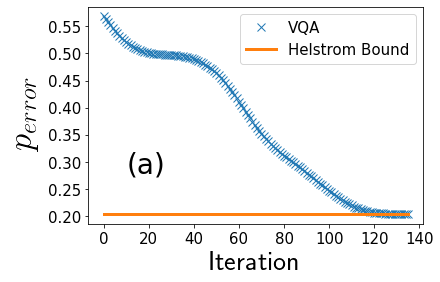

In [5]:
plt.plot(range(len(cost_list)), cost_list, 'x', markersize=8, label='VQA')
plt.plot(range(len(cost_list)), [val]*len(cost_list), linewidth=3, label='Helstrom Bound')
plt.xlabel('Iteration', usetex=True, fontsize=28)
plt.xticks(fontsize=15)
plt.ylabel(r'$p_{error}$', usetex=True, fontsize=35, labelpad=10)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.text(10, 0.28, '(a)', fontsize=28)
plt.savefig('./data/output1.png', bbox_inches='tight', transparent=True)
plt.show()

### Example 2
$|0\rangle, |1\rangle, |+\rangle$

#### State Preparation

In [2]:
def rho1(wires):
    qml.PauliX(wires=wires)
    qml.PauliX(wires=wires)

def rho2(wires):
    qml.PauliX(wires=wires)


def rho3(wires):
    qml.Hadamard(wires=wires)

#init_states = [np.array([1,0]), np.array([0,1]), np.array([1/np.sqrt(2),1/np.sqrt(2)])]
init_states = [np.array([1,0]), np.array([0,1]), np.array([1/np.sqrt(2),1/np.sqrt(2)])]

#### Variational Quantum Algorithm

In [4]:
n_outcome = 3
wires = [0, 1, 2]


devs = [qml.device('default.qubit', wires=len(wires))] * n_outcome
a_priori_probs = [1/n_outcome] * n_outcome


classifier = POVM_Clf(n_outcome, wires, devs, a_priori_probs, [rho1,rho2,rho3], 0)
cost_list = classifier.run_opt()


Cost(init_params)    : 0.5826322
Cost after step    20:  0.4719748
Cost after step    40:  0.4169448
Cost after step    60:  0.3877696
Cost after step    80:  0.3551777
Cost after step   100:  0.3376410
Cost after step   120:  0.3338623
Cost after step   140:  0.3336296
Cost after step   160:  0.3335205
Cost after step   180:  0.3334555
Cost after step   200:  0.3334182
Cost after step   220:  0.3333936
Cost after step   240:  0.3333769
Cost after step   260:  0.3333654
Cost after step   280:  0.3333572
Cost after step   300:  0.3333513
Cost after step   320:  0.3333470
Cost after step   340:  0.3333439
Cost after step   360:  0.3333415


#### SDP

In [5]:
val, E = sdp_med(init_states, n_outcome)
dp_probs(init_states, E)

Opt is Done. 
Status: optimal
Optimal Value: 0.33333333129189374


Measure                                      
                    0             1             2 sum_probs
State 0  1.000000e+00  2.136482e-09 -7.332397e-09       1.0
      1  2.136481e-09  1.000000e+00 -7.332396e-09       1.0
      2  5.000000e-01  5.000000e-01 -4.253625e-09       1.0

#### PGM

In [17]:
rhos = [np.outer(init_states[i],init_states[i]) for i in range(n_outcome)]

In [23]:
val_pgm, E_pgm = pgm(a_priori_probs,rhos)
print("Error Prob by PGMs:", val_pgm)
dp_probs(rhos, E_pgm)

Error Prob by PGMs: 0.34763107293781714


Measure                          
                0         1     2 sum_probs
State 0  0.728553  0.021447  0.25       1.0
      1  0.021447  0.728553  0.25       1.0
      2  0.250000  0.250000  0.50       1.0

#### Plot

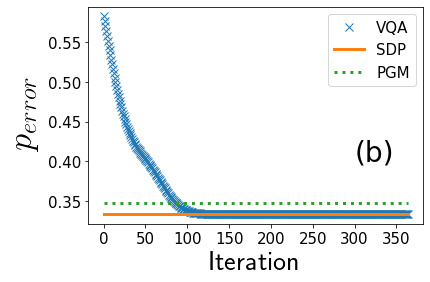

In [19]:
plt.plot(range(len(cost_list)), cost_list, 'x', markersize=8, label='VQA')
plt.plot(range(len(cost_list)), [val]*len(cost_list), linewidth=3, label='SDP')
plt.plot(range(len(cost_list)), [val_pgm]*len(cost_list), ':', linewidth=3, label='PGM')
plt.xlabel('Iteration', usetex=True, fontsize=28)
plt.ylabel(r'$p_{error}$', usetex=True, fontsize=35, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.text(300, 0.40, '(b)', fontsize=28)
plt.savefig('./data/output2.png', bbox_inches='tight', transparent=True)
plt.show()

### Example 3
$\rho_0$
$\rho_1$
$\rho_2$

#### State Preparation

In [26]:
def rho1(wires):
    theta = np.pi/5
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])

def rho2(wires):
    theta = np.pi/6
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])

def rho3(wires):
    theta = np.pi/8
    qml.RY(theta, wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])
    qml.Hadamard(wires[0])
    qml.S(wires=wires[0])
    qml.Hadamard(wires[1])
    qml.S(wires=wires[1])

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho1():
    rho1([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho2():
    rho2([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho3():
    rho3([0,1])
    return qml.state()

init_states = [rdm(classical_rho1()), rdm(classical_rho2()), rdm(classical_rho3())]

#### Variational Quantum Algorithm

In [27]:
n_outcome = 3
wires = [0, 1, 2, 3]


devs = [qml.device('default.qubit', wires=len(wires))] * n_outcome
a_priori_probs = [1/n_outcome] * n_outcome


classifier = POVM_Clf(n_outcome, wires[1:], devs, a_priori_probs, [rho1,rho2,rho3], wires[:2])
cost_list = classifier.run_opt()


Cost(init_params)    : 0.6809755
Cost after step    20:  0.6304650
Cost after step    40:  0.5777890
Cost after step    60:  0.5123100
Cost after step    80:  0.4619921
Cost after step   100:  0.4397077
Cost after step   120:  0.4337786
Cost after step   140:  0.4313902
Cost after step   160:  0.4305520
Cost after step   180:  0.4303849
Cost after step   200:  0.4303705


#### SDP

In [28]:
val, E = sdp_med(init_states, n_outcome)
dp_probs(init_states, E)

Opt is Done. 
Status: optimal
Optimal Value: 0.43037234214725456


Measure                              
                0         1         2 sum_probs
State 0  0.508258  0.238719  0.253024       1.0
      1  0.200598  0.570271  0.229131       1.0
      2  0.177915  0.191731  0.630354       1.0

#### PGM

In [30]:
val_pgm, E_pgm = pgm(a_priori_probs, init_states)
print("Error Prob by PGMs:", val_pgm)
dp_probs(rhos, E_pgm)

Error Prob by PGMs: 0.4732364749513911


Measure                              
                0         1         2 sum_probs
State 0  0.553509  0.229815  0.216676       1.0
      1  0.142283  0.437649  0.420069       1.0
      2  0.234465  0.556025  0.209510       1.0

#### Plot

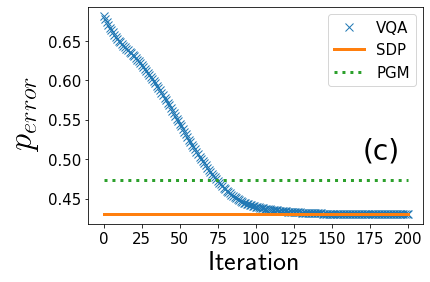

In [32]:
plt.plot(range(len(cost_list)), cost_list, 'x', markersize=8, label='VQA')
plt.plot(range(len(cost_list)), [val]*len(cost_list), linewidth=3, label='SDP')
plt.plot(range(len(cost_list)), [val_pgm]*len(cost_list), ':', linewidth=3, label='PGM')
plt.xlabel('Iteration', usetex=True, fontsize=28)
plt.ylabel(r'$p_{error}$', usetex=True, fontsize=35, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(fontsize=15)
plt.text(170, 0.5, '(c)', fontsize=28)
plt.savefig('./data/output3.png', bbox_inches='tight', transparent=True)
plt.show()

### Example 4
$\{|00\rangle+|11\rangle, |01\rangle+|10\rangle, |00\rangle, |++\rangle \}$

#### State Preparation

In [33]:
def rho1(wires):
    qml.Hadamard(wires=wires[0])
    qml.CNOT(wires=[wires[0],wires[1]])

def rho2(wires):
    qml.Hadamard(wires=wires[0])
    qml.PauliX(wires=wires[1])
    qml.CNOT(wires=[wires[0],wires[1]])
    
def rho3(wires):
    qml.PauliX(wires=wires[0])
    qml.PauliX(wires=wires[0])

def rho4(wires):
    qml.Hadamard(wires[0])
    qml.Hadamard(wires[1])

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho1():
    rho1([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho2():
    rho2([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho3():
    rho3([0,1])
    return qml.state()

@qml.qnode(qml.device("default.qubit", wires=2))
def classical_rho4():
    rho4([0,1])
    return qml.state()

init_states = [classical_rho1(), classical_rho2(), classical_rho3(), classical_rho4()]

#### Variational Quantum Algorithm

In [34]:
n_outcome = 4
wires = [0, 1, 2, 3]


devs = [qml.device('default.qubit', wires=len(wires))] * n_outcome
a_priori_probs = [1/n_outcome] * n_outcome


classifier = POVM_Clf(n_outcome, wires, devs, a_priori_probs, [rho1,rho2,rho3, rho4], [0,1])
cost_list = classifier.run_opt()

Cost(init_params)    : 0.7677308
Cost after step    20:  0.5239843
Cost after step    40:  0.4277432
Cost after step    60:  0.3905114
Cost after step    80:  0.3785710
Cost after step   100:  0.3761241
Cost after step   120:  0.3720436
Cost after step   140:  0.3579180
Cost after step   160:  0.3372230
Cost after step   180:  0.3243187
Cost after step   200:  0.3234130
Cost after step   220:  0.3232825
Cost after step   240:  0.3232509
Cost after step   260:  0.3232409
Cost after step   280:  0.3232357
Cost after step   300:  0.3232323


#### SDP

In [35]:
val, E = sdp_med(init_states, n_outcome)
dp_probs(init_states, E)

Opt is Done. 
Status: optimal
Optimal Value: 0.32322345402794006


Measure                                                
                0             1         2             3 sum_probs
State 0  0.853555 -5.529569e-07  0.146446 -4.358923e-07       1.0
      1  0.000001  9.999964e-01  0.000001  1.280249e-06       1.0
      2  0.146446 -5.584355e-07  0.853555 -5.187680e-07       1.0
      3  0.426778  4.999979e-01  0.073224  5.053519e-07       1.0

#### PGM

In [40]:
rhos = [np.outer(init_states[i],init_states[i]) for i in range(n_outcome)]

In [41]:
val_pgm, E_pgm = pgm(a_priori_probs, rhos)
print("Error Prob by PGMs:", val_pgm)
dp_probs(rhos, E_pgm)

Error Prob by PGMs: 0.3336334812758035


Measure                                        
                0         1         2         3 sum_probs
State 0  0.638936  0.018484  0.122545  0.220035       1.0
      1  0.018484  0.724433  0.001342  0.255740       1.0
      2  0.122545  0.001342  0.826993  0.049121       1.0
      3  0.220035  0.255740  0.049121  0.475104       1.0

#### Plot

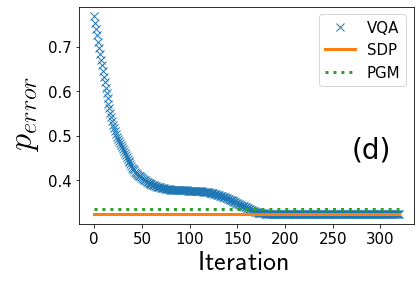

In [42]:
plt.plot(range(len(cost_list)), cost_list, 'x', markersize=8, label='VQA')
plt.plot(range(len(cost_list)), [val]*len(cost_list), linewidth=3, label='SDP')
plt.plot(range(len(cost_list)), [val_pgm]*len(cost_list), ":", linewidth=3, label='PGM')
plt.xlabel('Iteration', usetex=True, fontsize=28)
plt.ylabel(r'$p_{error}$', usetex=True, fontsize=35, labelpad=10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
#plt.ylim([0.35,0.40,0.45,0.50,0.55,0.60,0.65,0.70])
plt.legend(fontsize=15)
plt.text(270, 0.45, '(d)', fontsize=28)
plt.savefig('./data/output4.png', bbox_inches='tight', transparent=True)

## 2. Classifying Iris Dataset

### 2-1. Single-qubit POVM-based Classifier

#### Quantum Feature Map

In [6]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X)
#X = 0.2 * (affine_preprocessing(X, minmax='0-to-2pi') - np.pi)
enc_type='invcoscos'
#enc_type='gaussian'

In [7]:
X

tensor([[-3.49065850e-01,  1.57079633e-01, -5.43122798e-01,
         -5.75958653e-01],
        [-4.18879020e-01, -1.04719755e-01, -5.43122798e-01,
         -5.75958653e-01],
        [-4.88692191e-01,  0.00000000e+00, -5.64421731e-01,
         -5.75958653e-01],
        [-5.23598776e-01, -5.23598776e-02, -5.21823864e-01,
         -5.75958653e-01],
        [-3.83972435e-01,  2.09439510e-01, -5.43122798e-01,
         -5.75958653e-01],
        [-2.44346095e-01,  3.66519143e-01, -4.79225998e-01,
         -4.71238898e-01],
        [-5.23598776e-01,  1.04719755e-01, -5.43122798e-01,
         -5.23598776e-01],
        [-3.83972435e-01,  1.04719755e-01, -5.21823864e-01,
         -5.75958653e-01],
        [-5.93411946e-01, -1.57079633e-01, -5.43122798e-01,
         -5.75958653e-01],
        [-4.18879020e-01, -5.23598776e-02, -5.21823864e-01,
         -6.28318531e-01],
        [-2.44346095e-01,  2.61799388e-01, -5.21823864e-01,
         -5.75958653e-01],
        [-4.53785606e-01,  1.04719755e-01, 

Data-Embedded Reduced Density States on Bloch Sphere

In [8]:
quFeatmap = QuantumEmbedding(wires=[0,1], enc_type=enc_type)

dev = qml.device("default.qubit", wires=2)
@qml.qnode(dev)
def data_state(input):
    quFeatmap(input)
    return qml.state()

bloch_list = []
for i in range(len(X)):
    bloch_list.append(rho_2_bloch(rdm(data_state(X[i]))))

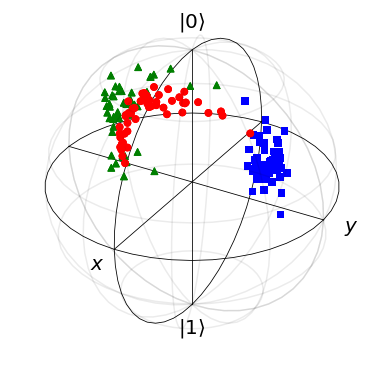

In [25]:
import qutip as qt

b = qt.Bloch()
b.make_sphere()
b.point_color = ['b'] * 50 + ['r'] * 50 + ['g'] * 50
b.point_marker = ['s'] * 50 + ['o'] * 50 + ['^'] * 50
b.point_size = [45] * 150
b.view = [0,30]
b.frame_alpha = 0.08
b.frame_width = 0.8
b.frame_color = 'black'
b.sphere_alpha = 0.0
b.sphere_color = 'skyblue'
for i in range(50):
    b.add_points(bloch_list[i].tolist())

for i in range(50,100):
    b.add_points(bloch_list[i].tolist())

for i in range(100,150):
    b.add_points(bloch_list[i].tolist())

b.show()
b.save()

#### Training POVM-based classifier

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=30/150,
                                                    stratify=y,
                                                    random_state=3) #35
print([np.count_nonzero(y_train == i) for i in range(3)])

[40, 40, 40]


In [23]:
num_measuring_qubits = 1
num_povm = 3

clf = POVMbasedCLF(num_measuring_qubits, num_povm)

In [16]:
clf.fit(X_train, y_train, enc_type=enc_type)

Cost(init_params)    :  0.7085710
Cost after step   20 :  0.6647043
Cost after step   40 :  0.6176799
Cost after step   60 :  0.5430399
Cost after step   80 :  0.5175331
Cost after step  100 :  0.5134721
Cost after step  120 :  0.5123426
Cost after step  140 :  0.5122226
Cost after step  160 :  0.5122005


#### Test

In [17]:
print('Quantum Embedding Type:', quFeatmap.embedding_type)
if quFeatmap.embedding_type == 'qfeat':
    print('Layer:',quFeatmap.layer, '| enc_type:',quFeatmap.enc_type)

print('Training size:', len(y_train), 
        '| Success:', np.count_nonzero(y_train == clf.predict(X_train)))

outcome = clf.predict(X_test)
print('Test size:', len(y_test), 
        '| Success:', np.count_nonzero(y_test == outcome), 
        '| Ratio:', np.count_nonzero(y_test == outcome)/len(y_test))

Quantum Embedding Type: qfeat
Layer: 2 | enc_type: invcoscos
Training size: 120 | Success: 103
Test size: 30 | Success: 24 | Ratio: 0.8


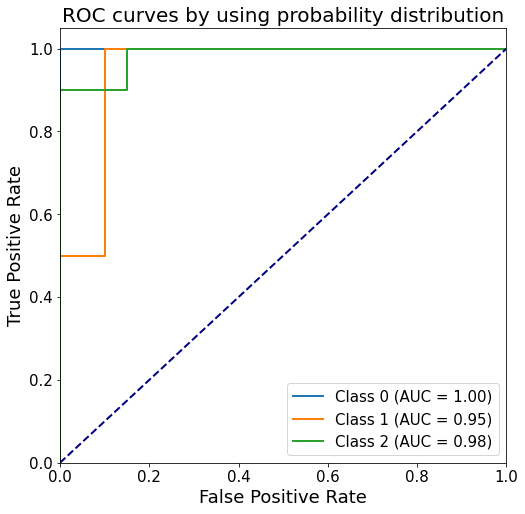

In [18]:
y_scores = clf.probs_predict[:,:3]
plot_ROC_curve(y_test, y_scores)

#### Accuracy w.r.t. the size of dataset

In [ ]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X)
enc_type='invcoscos'


size_list = list(range(3, 120+3, 3))
accuracy_list = []
for size in size_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=(150-size)/150,
                                                    stratify=y,
                                                    random_state=1)

    num_measuring_qubits, num_povm = 1, 3
    clf = POVMbasedCLF(num_measuring_qubits, num_povm)
    clf.fit(X_train, y_train, enc_type=enc_type)

    outcome = clf.predict(X_test)
    accuracy_list.append(np.count_nonzero(y_test == outcome)/len(y_test))

np.save('1qpovm_accuracy.npy', accuracy_list)

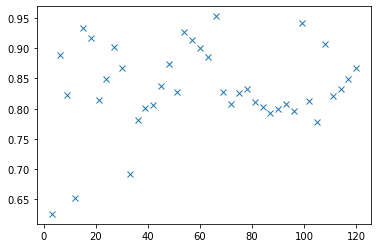

In [26]:
plt.plot(size_list, accuracy_list, 'x')

Plots w.r.t. seed #

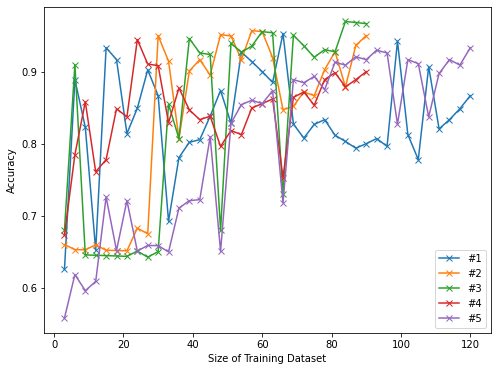

In [5]:
plt.figure(figsize=(8, 6))

accrc_list = []
for i in range(1, 6):
    accrc_list.append(np.load('1qpovm_accuracy_seed'+str(i)+'.npy'))

    plt.plot(range(3, 3*(len(accrc_list[i-1])+1), 3), accrc_list[i-1], 'x-',label='#'+str(i))

plt.xlabel('Size of Training Dataset')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#### 5-fold Cross Validation

In [4]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X)

enc_type='invcoscos'

cv = StratifiedKFold(n_splits=5)

In [5]:
num_measuring_qubits = 1
num_povm = 3

clf = POVMbasedCLF(num_measuring_qubits, num_povm)

In [6]:
probs_preds = []
label_preds = []
label_ys = []
accuracy_list = []

for i, (train_index,test_index) in enumerate(cv.split(X, y)):
    #print(i, test_index)
    clf.fit(X[train_index], y[train_index], enc_type=enc_type)

    # y labels
    label_ys.append(y[test_index])

    # Predictive labels
    label_pred = clf.predict(X[test_index])
    label_preds.append(label_pred)

    # Prediction Probabilities
    probs_preds.append(clf.probs_predict[:,:num_povm])

    

    # Displaying Results 
    quFeatmap = QuantumEmbedding(wires=[0,1], enc_type=enc_type)
    print('Quantum Embedding Type:', quFeatmap.embedding_type)
    if quFeatmap.embedding_type == 'qfeat':
        print('Layer:',quFeatmap.layer, '| enc_type:',quFeatmap.enc_type)

    print('Training size:', len(y[train_index]), 
            '| Success:', np.count_nonzero(y[train_index] == clf.predict(X[train_index])))

    accuracy = np.count_nonzero(y[test_index] == label_pred)/len(y[test_index])
    accuracy_list.append(accuracy)
    print('Test size:', len(y[test_index]), 
            '| Success:', np.count_nonzero(y[test_index] == label_pred), 
            '| Ratio:', accuracy)

Cost(init_params)    :  0.7078896
Cost after step   20 :  0.6643903
Cost after step   40 :  0.6142696
Cost after step   60 :  0.5417910
Cost after step   80 :  0.5183592
Cost after step  100 :  0.5141783
Cost after step  120 :  0.5130521
Cost after step  140 :  0.5129203
Cost after step  160 :  0.5128935
Quantum Embedding Type: qfeat
Layer: 2 | enc_type: invcoscos
Training size: 120 | Success: 103
Test size: 30 | Success: 26 | Ratio: 0.8666666666666667
Cost(init_params)    :  0.5130669
Quantum Embedding Type: qfeat
Layer: 2 | enc_type: invcoscos
Training size: 120 | Success: 111
Test size: 30 | Success: 28 | Ratio: 0.9333333333333333
Cost(init_params)    :  0.5101544
Quantum Embedding Type: qfeat
Layer: 2 | enc_type: invcoscos
Training size: 120 | Success: 104
Test size: 30 | Success: 26 | Ratio: 0.8666666666666667
Cost(init_params)    :  0.5103408
Quantum Embedding Type: qfeat
Layer: 2 | enc_type: invcoscos
Training size: 120 | Success: 113
Test size: 30 | Success: 28 | Ratio: 0.93333

In [7]:
np.mean(accuracy_list), np.std(accuracy_list)

(0.8933333333333333, 0.03265986323710904)

[Mean ROC Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

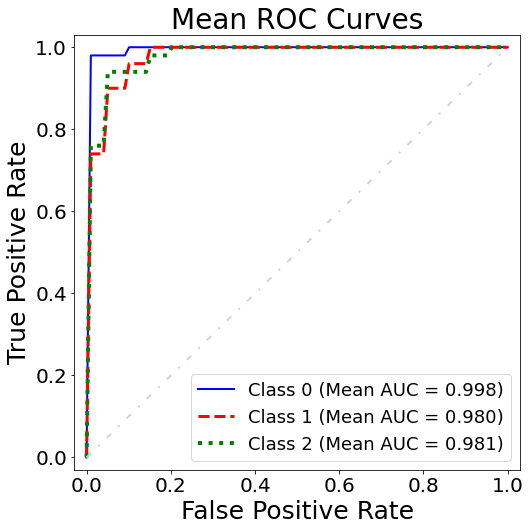

In [8]:
plot_mean_ROC_curve(label_ys, probs_preds, 3, 5)

### 2-2. Two-qubit POVM-based Classifier

#### Iris Dataset 

In [3]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X) #, minmax='0-to-2pi')
#X = .1 * (affine_preprocessing(X, minmax='0-to-2pi')) #- np.pi) #, minmax='0-to-2pi')

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=30/150,
                                                    stratify=y,
                                                    random_state=2) #35
print([np.count_nonzero(y_train == i) for i in range(3)])

[40, 40, 40]


#### Training POVM-based classifier by using Quantum Feature Map

In [4]:
num_measuring_qubits = 2
num_povm = 3
#wires = [0, 1, 2, 3]
clf = POVMbasedCLF(num_measuring_qubits, num_povm)

In [5]:
clf.fit(X_train, y_train)
# 34m 13.9s

Cost(init_params)    :  0.6748065
Cost after step   20 :  0.4906207
Cost after step   40 :  0.4333764
Cost after step   60 :  0.4049859
Cost after step   80 :  0.3910283
Cost after step  100 :  0.3718884
Cost after step  120 :  0.3491641
Cost after step  140 :  0.3358152
Cost after step  160 :  0.3306940
Cost after step  180 :  0.3295476
Cost after step  200 :  0.3294238


#### Test

In [6]:
qdata = QuantumEmbedding([0,1])
print('Quantum Encoding Type:', qdata.enc_type)
if qdata.enc_type == 'qfeat':
    print('Layer:', qdata.layer, '| feat_type:', qdata.feat_type)

print('Training size:', len(y_train), 
        '| Success:', np.count_nonzero(y_train == clf.predict(X_train)))

outcome = clf.predict(X_test)
print('Test size:', len(y_test), 
        '| Success:', np.count_nonzero(y_test == outcome), 
        '| Ratio:', np.count_nonzero(y_test == outcome)/len(y_test))

Quantum Encoding Type: gaussian
Training size: 120 | Success: 108
Test size: 30 | Success: 30 | Ratio: 1.0


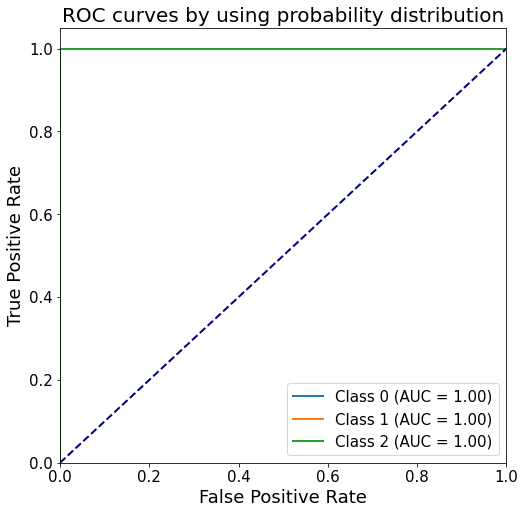

In [7]:
y_scores = clf.probs_predict[:,:3]
plot_ROC_curve(y_test, y_scores)

#### Accuracy w.r.t. the size of dataset

In [6]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X)


size_list = list(range(3, 120+3, 3))
accuracy_list = []
for size in size_list:
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=(150-size)/150,
                                                    stratify=y,
                                                    random_state=2)

    num_measuring_qubits, num_povm = 2, 3
    clf = POVMbasedCLF(num_measuring_qubits, num_povm)
    clf.fit(X_train, y_train)

    outcome = clf.predict(X_test)
    accuracy_list.append(np.count_nonzero(y_test == outcome)/len(y_test))

np.save('2qpovm_accuracy.npy', accuracy_list)

Cost(init_params)    :  0.6311644
Cost after step   20 :  0.4833248
Cost after step   40 :  0.3716727
Cost after step   60 :  0.3174643
Cost after step   80 :  0.3100450
Cost(init_params)    :  0.6655377
Cost after step   20 :  0.4997579
Cost after step   40 :  0.4428038
Cost after step   60 :  0.4049879
Cost after step   80 :  0.3735441
Cost after step  100 :  0.3532608
Cost after step  120 :  0.3462621
Cost after step  140 :  0.3447402
Cost after step  160 :  0.3446241
Cost(init_params)    :  0.6650888
Cost after step   20 :  0.4956380
Cost after step   40 :  0.4368109
Cost after step   60 :  0.4035669
Cost after step   80 :  0.3832569
Cost after step  100 :  0.3666771
Cost after step  120 :  0.3566548
Cost after step  140 :  0.3531072
Cost after step  160 :  0.3524851
Cost after step  180 :  0.3524410
Cost(init_params)    :  0.6637009
Cost after step   20 :  0.4872954
Cost after step   40 :  0.4301266
Cost after step   60 :  0.3996365
Cost after step   80 :  0.3827165
Cost after ste

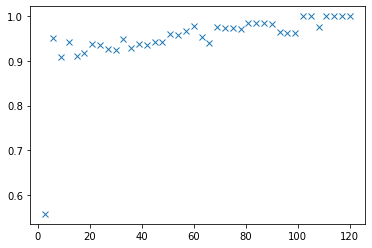

In [8]:
plt.plot(size_list, accuracy_list, 'x')

#### 5-fold Cross Validation

In [9]:
X, y = load_iris().data, load_iris().target
X = 0.2 * np.pi * affine_preprocessing(X)

cv = StratifiedKFold(n_splits=5)

In [10]:
num_measuring_qubits = 2
num_povm = 3

clf = POVMbasedCLF(num_measuring_qubits, num_povm)

In [11]:
probs_preds = []
label_preds = []
label_ys = []
accuracy_list = []

for i, (train_index,test_index) in enumerate(cv.split(X, y)):
    #print(i, test_index)
    clf.fit(X[train_index], y[train_index])

    # y labels
    label_ys.append(y[test_index])

    # Predictive labels
    label_pred = clf.predict(X[test_index])
    label_preds.append(label_pred)

    # Prediction Probabilities
    probs_preds.append(clf.probs_predict[:,:num_povm])

    

    # Displaying Results 
    qdata = QuantumEmbedding([0,1])
    print('Quantum Encoding Type:', qdata.enc_type)
    if qdata.enc_type == 'qfeat':
        print('Layer:', qdata.layer, '| feat_type:', qdata.feat_type)

    print('Training size:', len(y[train_index]), 
            '| Success:', np.count_nonzero(y[train_index] == clf.predict(X[train_index])))

    accuracy = np.count_nonzero(y[test_index] == label_pred)/len(y[test_index])
    accuracy_list.append(accuracy)
    print('Test size:', len(y[test_index]), 
            '| Success:', np.count_nonzero(y[test_index] == label_pred), 
            '| Ratio:', accuracy)

Cost(init_params)    :  0.6767433
Cost after step   20 :  0.4924288
Cost after step   40 :  0.4354683
Cost after step   60 :  0.4064368
Cost after step   80 :  0.3875102
Cost after step  100 :  0.3620039
Cost after step  120 :  0.3401673
Cost after step  140 :  0.3292411
Cost after step  160 :  0.3257984
Cost after step  180 :  0.3251876
Cost after step  200 :  0.3251427
Quantum Encoding Type: gaussian
Training size: 120 | Success: 113
Test size: 30 | Success: 25 | Ratio: 0.8333333333333334
Cost(init_params)    :  0.3249045
Quantum Encoding Type: gaussian
Training size: 120 | Success: 109
Test size: 30 | Success: 29 | Ratio: 0.9666666666666667
Cost(init_params)    :  0.3251615
Quantum Encoding Type: gaussian
Training size: 120 | Success: 110
Test size: 30 | Success: 28 | Ratio: 0.9333333333333333
Cost(init_params)    :  0.3271541
Quantum Encoding Type: gaussian
Training size: 120 | Success: 112
Test size: 30 | Success: 26 | Ratio: 0.8666666666666667
Cost(init_params)    :  0.3314654
Qu

In [12]:
np.mean(accuracy_list), np.std(accuracy_list)

(0.9199999999999999, 0.06182412330330468)

In [ ]:
np.save('label_ys', label_ys)
np.save('probs_preds', probs_preds)

[Mean ROC Curves](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py)

In [2]:
label_ys = np.load('label_ys.npy')
probs_preds= np.load('probs_preds.npy')

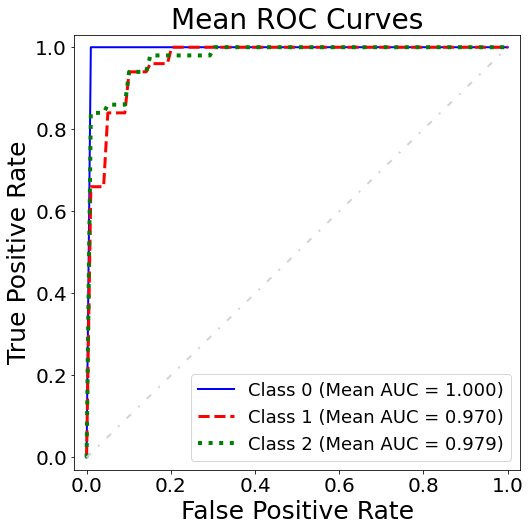

In [3]:
plot_mean_ROC_curve(label_ys, probs_preds, 3, 5)